In [2]:
# This cell loads the necessary packages automatically
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Import libraries

In [3]:
import arviz as az
import pandas as pd
import numpy as np
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import jax
from jax import random
import json

from src.models import pooled, no_pooled, hierarchical, hierarchical_ind_occ, hierarchical_ind_occ_orig
from src.utils import filter_data
from numpyro.infer import MCMC, NUTS, Predictive

I0000 00:00:1698763536.708648    5074 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


In [4]:
import warnings
warnings.filterwarnings('ignore')

## Import data

In [5]:
data = pd.read_csv('../datasets/model_dataset_cleaned.csv', index_col=0)
data.head(3)

,year,industry,occup,exp,salary,sex,no_edu,elementary_edu,highschool_edu,postsec_edu,undergrad_edu,graduate_edu,tenure,union,public_sector,self_emp,age,min_wage,estimated_hourly_wage,below_min_wage
0,1997,info/culture,other trades,5.0,78385.474860,0,0,0,0,1,0,0,55.0,0,0,0,26.0,11.974439,43.068942,0
1,1997,trade,clerical/supervisor,1.0,32225.139665,0,0,0,1,0,0,0,13.0,0,0,0,34.0,11.974439,17.706121,0
2,1997,utilities,operators/assemblers,12.0,62708.379888,0,0,0,0,0,1,0,138.0,1,1,0,34.0,11.974439,34.455154,0


In [6]:
# Convert industries and occupations to categorical and create codes columns
ind_cat = [
    'agriculture',
    'forestry/oil/mining',
    'utilities',
    'construction',
    'manufacturing',
    'trade',
    'transportation',
    'info/culture',
    'finance/real estate',
    'scientific/technical',
    'business support',
    'education',
    'health/social',
    'accommodation/food',
    'other services',
    'public admin']
data["industry"] = pd.Categorical(data["industry"], categories=ind_cat)
data["ind_codes"] = data["industry"].cat.codes

occ_cat = ['senior management',
    'middle management',
    'business/finance professional',
    'secretarial/administrative',
    'natural/sciences professional',
    'technical specialist',
    'health professional',
    'health assistant',
    'teachers/professors',
    'government/religion services',
    'protective services',
    'childcare/home support',
    'art/culture occupations',
    'clerical/supervisor',
    'chefs/food services',
    'sales/service',
    'clerks/cashiers',
    'construction trades',
    'transport/equipment operators',
    'trade helper/labourer',
    'trades contractors/supervisors',
    'other trades',
    'operators/assemblers',
    'manufacturing labourer']
data["occup"] = pd.Categorical(data["occup"], categories=occ_cat)
data["occ_codes"] = data["occup"].cat.codes

In [7]:
# Read standardization parameters (from training set)
with open('src/standardization_params.json', 'rb') as f:
    std_params = json.load(f)

print(std_params)

# Standardize data
data["exp"] = (data["exp"] - std_params["exp"]["mean"]) / std_params["exp"]["std"]
data["age"] = (data["age"] - std_params["age"]["mean"]) / std_params["age"]["std"]
data["tenure"] = (data["tenure"] - std_params["tenure"]["mean"]) / std_params["tenure"]["std"]

{'exp': {'mean': 17.518549260194874, 'std': 10.989387205110251}, 'age': {'mean': 40.64072536990256, 'std': 10.609588656407302}, 'tenure': {'mean': 120.3662215806568, 'std': 108.69970045476138}}


In [8]:
model_name = "hierarchical-ind-occ"
model = az.from_netcdf(f'../outputs/{model_name}/2007/trace.nc')
model

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

In [9]:
with open(f'../outputs/{model_name}/2007/model.pickle', 'rb') as f:
    mcmc = pickle.load(f)
samples = mcmc.get_samples()

In [10]:
predictive = Predictive(hierarchical_ind_occ, samples)

In [11]:
validation_data = data[data["year"] >= 2008]

# Drop rows based on index
validation_data = validation_data.drop(validation_data.index[[63, 3993]])

In [12]:
rng_key = random.PRNGKey(0)
feature_names = ['exp','sex','no_edu','elementary_edu','highschool_edu','postsec_edu',
                 'undergrad_edu','graduate_edu','age','tenure','union','public_sector','self_emp']
# X, y, ind = filter_data(2008, validation_data, columns=None, occ_dim=False, operator=">=")
# predictions = predictive(rng_key, X, None, ind, feature_names)["salary_hat"]
X, y, ind, occ = filter_data(2008, validation_data, columns=None, occ_dim=True, operator=">=")
predictions = predictive(rng_key, X, None, ind, occ, feature_names)["salary_hat"]

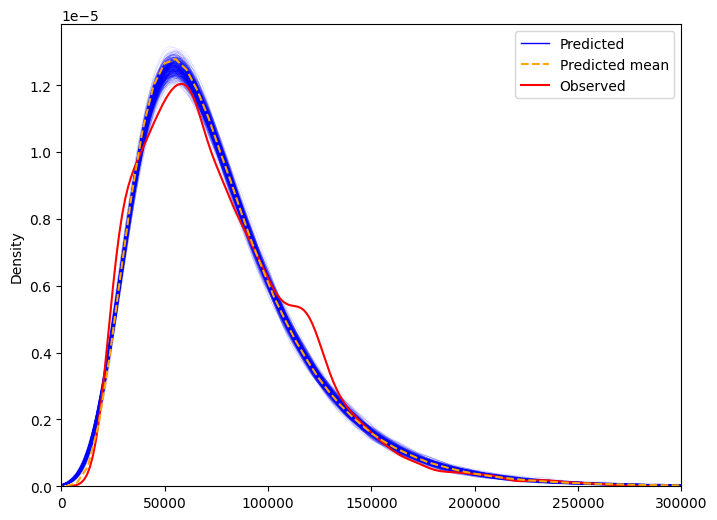

In [13]:
# plot kde of praedictions and actual values
fig, ax = plt.subplots(figsize=(8, 6))
pred_samples = 500
for i in range(pred_samples):
    sns.kdeplot(predictions[i], label="Predicted", alpha=0.5, linewidth=0.1, color="blue")

sns.kdeplot(y, label="Observed", color="red")
sns.kdeplot(predictions[:pred_samples].flatten(), label="Predicted mean", color="orange", linestyle="--")

# Add actual and last predicted label to legend
handles, labels = ax.get_legend_handles_labels()

handles = [handles[0], handles[-1], handles[-2]]
labels = [labels[0], labels[-1], labels[-2]]

legend = ax.legend(handles, labels, loc="best");
legend.get_lines()[0].set_alpha(1)
legend.get_lines()[0].set_linewidth(1)
plt.xlim(0, 300000);

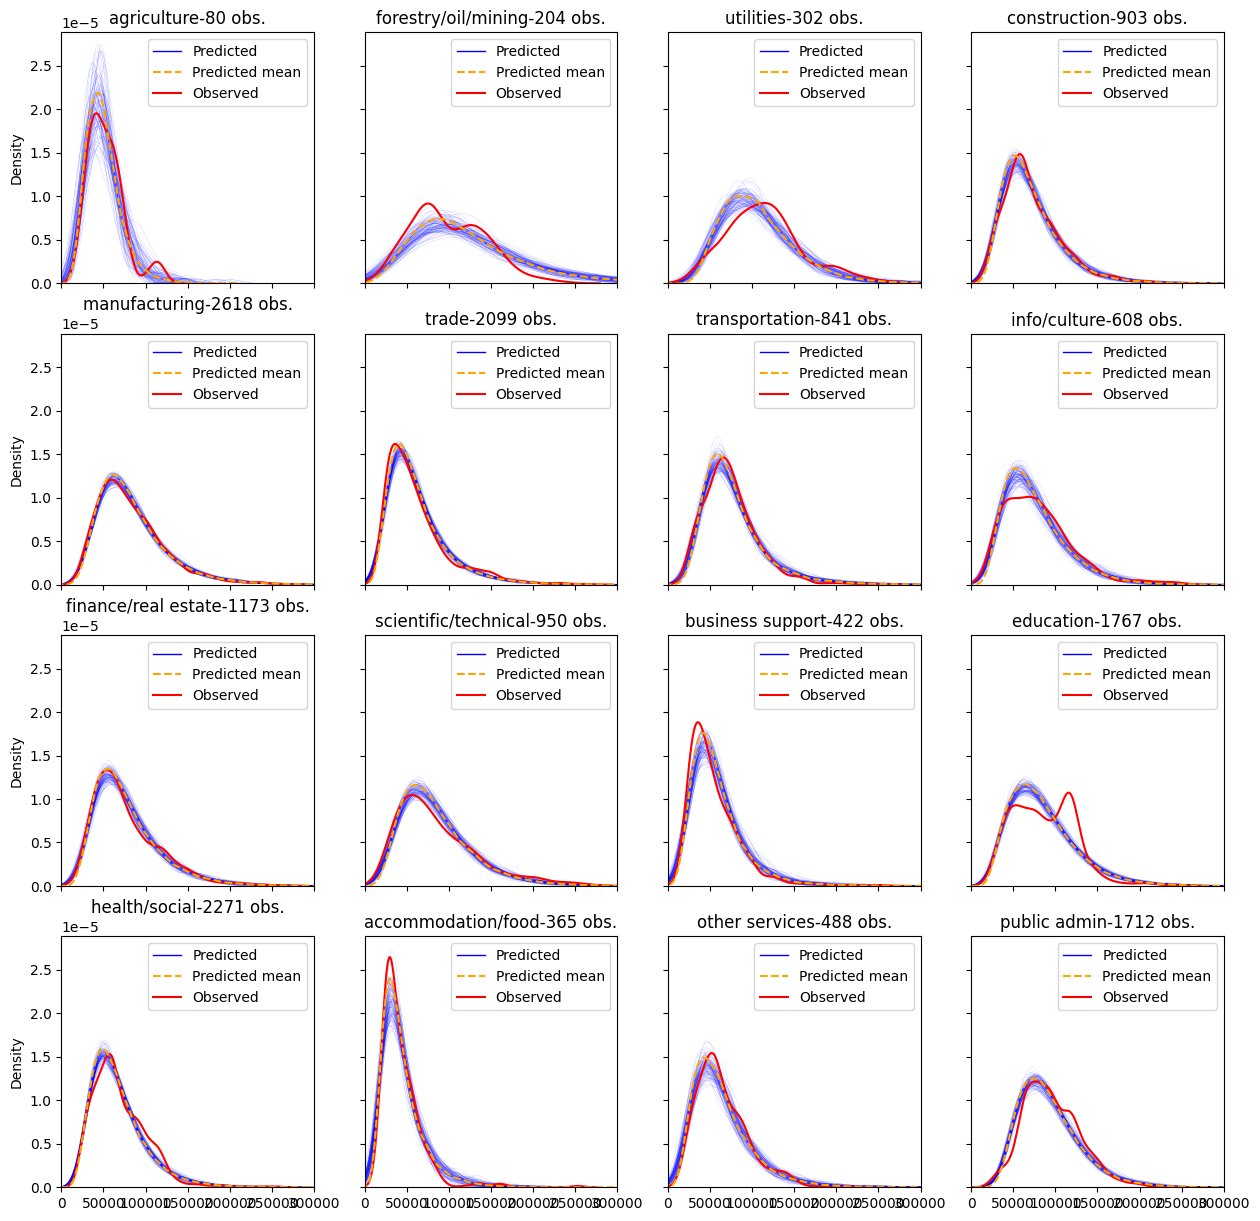

In [14]:
# plot kde of praedictions and actual values
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(15, 15), sharex=True, sharey=True)
for i in range(16):
    ind_code = i
    ind_pred = predictions[:, (ind == ind_code)]
    ind_y = y[ind == ind_code]
    pred_samples = 100
    for j in range(pred_samples):
        sns.kdeplot(ind_pred[j], label="Predicted", alpha=0.5, linewidth=0.1, color="blue", ax=ax[i//4, i%4])

    sns.kdeplot(ind_y, label="Observed", color="red", ax=ax[i//4, i%4])
    sns.kdeplot(ind_pred[:pred_samples].flatten(), label="Predicted mean", color="orange", linestyle="--", ax=ax[i//4, i%4])

    # Add actual and last predicted label to legend
    handles, labels = ax[i//4, i%4].get_legend_handles_labels()

    handles = [handles[0], handles[-1], handles[-2]]
    labels = [labels[0], labels[-1], labels[-2]]

    legend = ax[i//4, i%4].legend(handles, labels, loc="best");
    legend.get_lines()[0].set_alpha(1)
    legend.get_lines()[0].set_linewidth(1)
    ax[i//4, i%4].set_xlim(0, 3e5);
    ax[i//4, i%4].set_title(f"{ind_cat[i]}-{len(ind_y)} obs.")

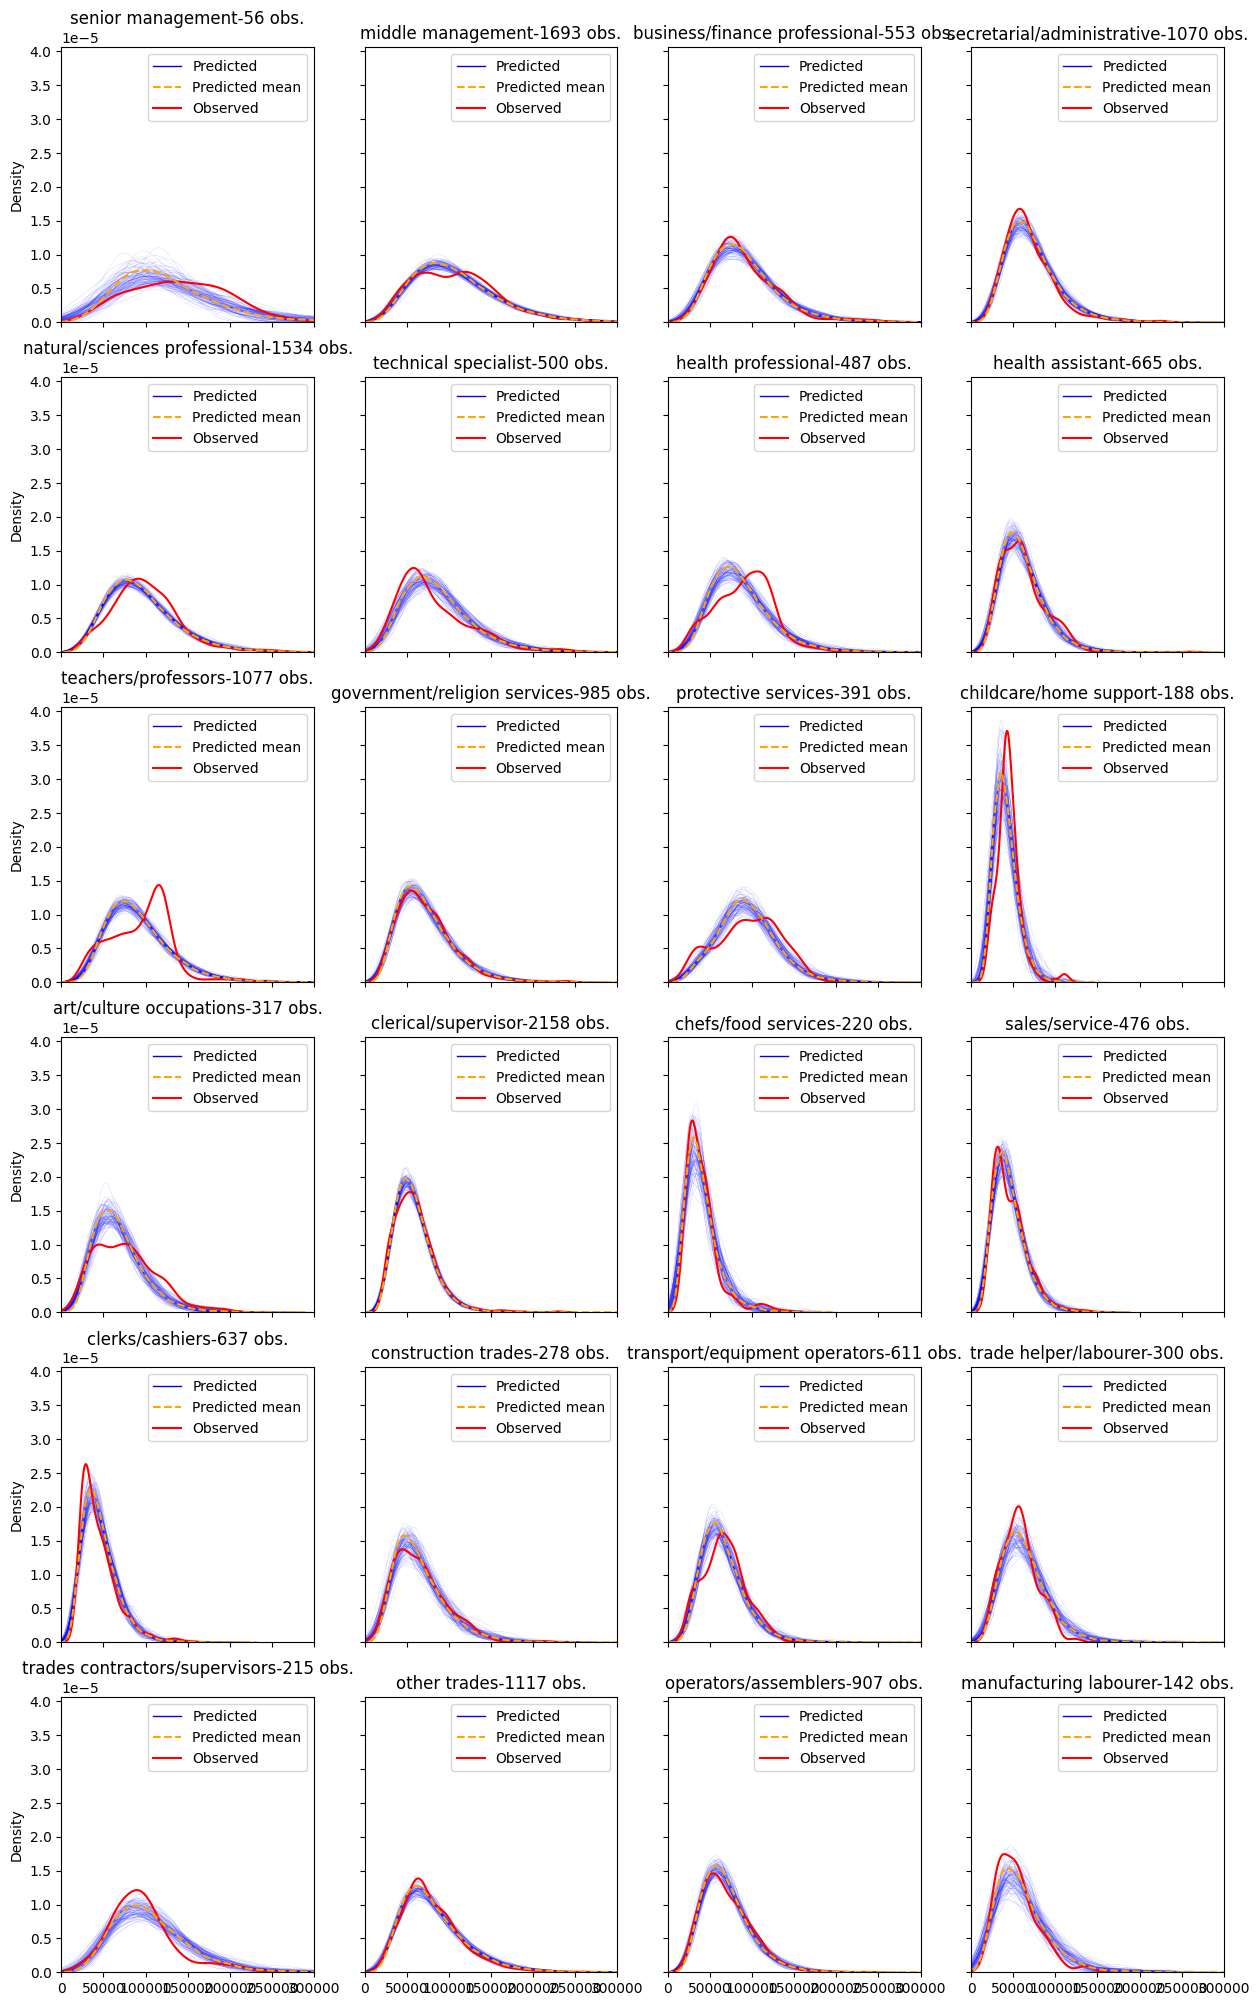

In [15]:
# plot kde of praedictions and actual values
fig, ax = plt.subplots(ncols=4, nrows=6, figsize=(15, 25), sharex=True, sharey=True)
for i in range(24):
    occ_code = i
    occ_pred = predictions[:, (occ == occ_code)]
    occ_y = y[occ == occ_code]
    pred_samples = 100
    for j in range(pred_samples):
        sns.kdeplot(occ_pred[j], label="Predicted", alpha=0.5, linewidth=0.1, color="blue", ax=ax[i//4, i%4])

    sns.kdeplot(occ_y, label="Observed", color="red", ax=ax[i//4, i%4])
    sns.kdeplot(occ_pred[:pred_samples].flatten(), label="Predicted mean", color="orange", linestyle="--", ax=ax[i//4, i%4])

    # Add actual and last predicted label to legend
    handles, labels = ax[i//4, i%4].get_legend_handles_labels()

    handles = [handles[0], handles[-1], handles[-2]]
    labels = [labels[0], labels[-1], labels[-2]]

    legend = ax[i//4, i%4].legend(handles, labels, loc="best");
    legend.get_lines()[0].set_alpha(1)
    legend.get_lines()[0].set_linewidth(1)
    ax[i//4, i%4].set_xlim(0, 3e5);
    ax[i//4, i%4].set_title(f"{occ_cat[i]}-{len(occ_y)} obs.");

In [16]:
def duplicates_query(row):
    return " and ".join([f"{col} == {value}" for col, value in row.items()])

In [17]:
def count_duplicates(row, df):
    query = duplicates_query(row)
    return df.query(query).shape[0]

In [18]:
similar_fields = ['sex','no_edu','elementary_edu','highschool_edu','postsec_edu','undergrad_edu','graduate_edu',
                  'union','public_sector','self_emp','ind_codes','occ_codes']
validation_data["count_similar_individuals"] = validation_data[similar_fields].apply(lambda row: count_duplicates(row, validation_data), axis=1)
validation_data.reset_index(inplace=True, drop=True)

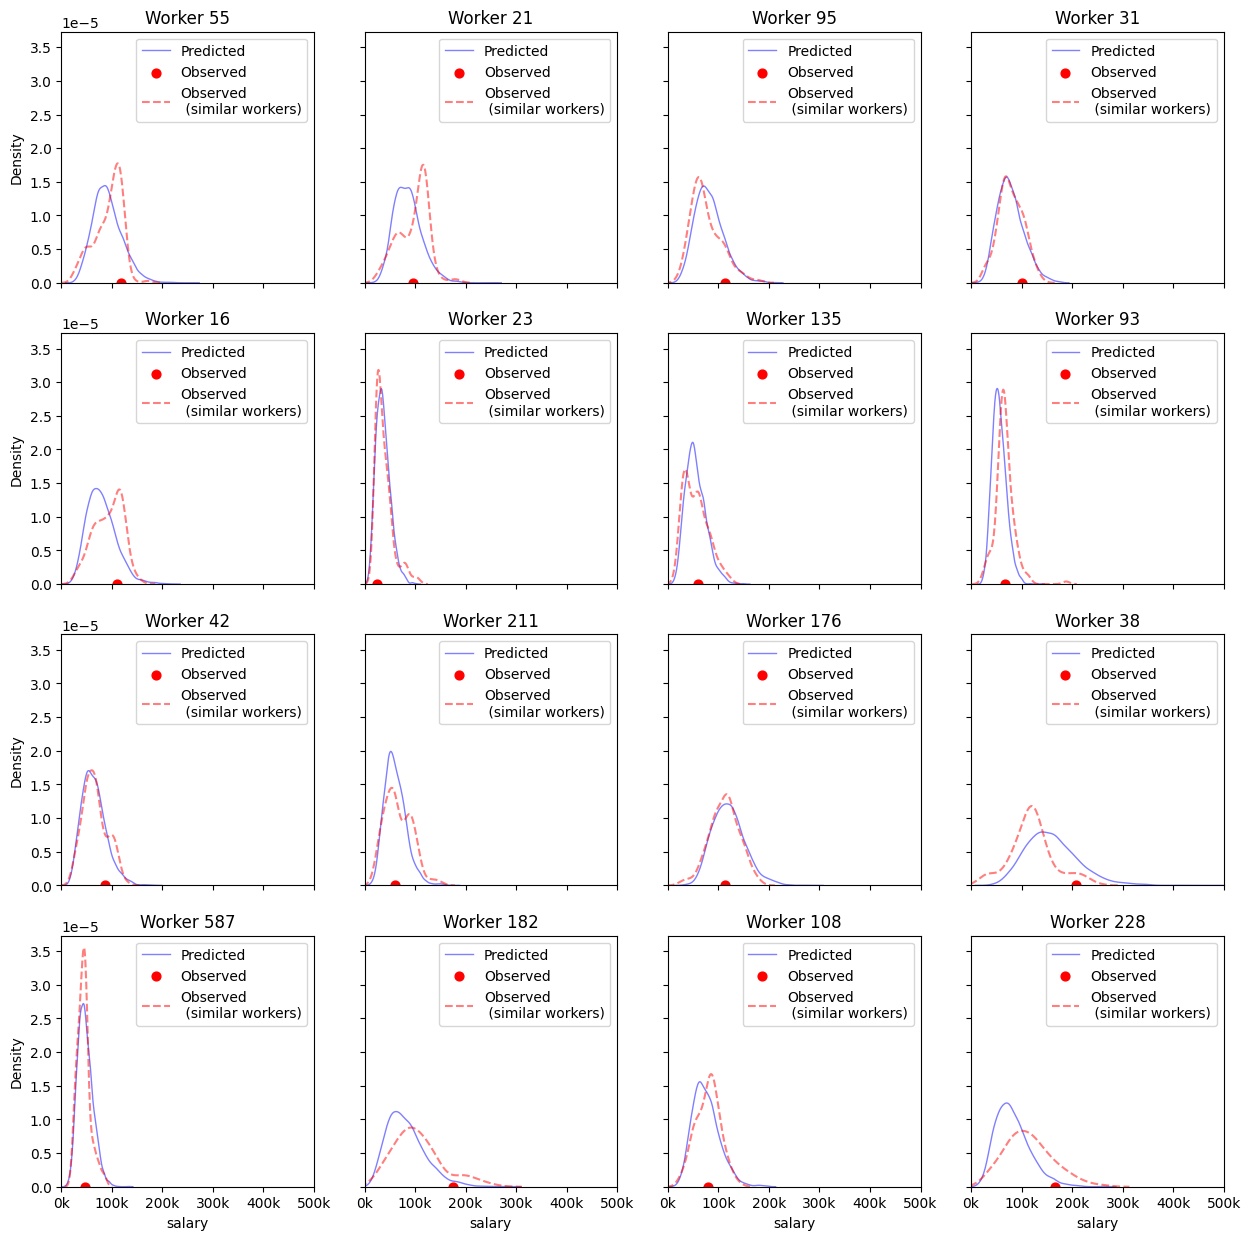

In [19]:
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(15, 15), sharex=True, sharey=True)

# get 10 random individuals
random_individuals = validation_data[validation_data.duplicated(subset=similar_fields) == False].sort_values(by="count_similar_individuals", ascending=False).head(16)

id_chart = 0
for i, ind in random_individuals.iterrows():
    sns.kdeplot(predictions[:, i], label="Predicted", alpha=0.5, linewidth=1, color="blue", ax=ax[id_chart//4, id_chart%4])
    ax[id_chart//4, id_chart%4].scatter(ind["salary"], 0, color="red", s=40, label="Observed")

    # Filter similar individuals
    query = duplicates_query(ind[similar_fields])
    obs_similar_salaries = validation_data.query(query)["salary"]
    sns.kdeplot(obs_similar_salaries, label="Observed\n (similar workers)", color="red", alpha=0.5,linestyle="--", ax=ax[id_chart//4, id_chart%4])

    ax[id_chart//4, id_chart%4].legend();
    ax[id_chart//4, id_chart%4].set_title(f"Worker {i}");
    ax[id_chart//4, id_chart%4].set_xlim(0, 5e5);
    ax[id_chart//4, id_chart%4].set_xticklabels([f"{int(tick/1000)}k" for tick in ax[id_chart//4, id_chart%4].get_xticks()])

    id_chart += 1


In [284]:
validation_data.loc[680]

year                                                 2008
industry                                    health/social
occup                        government/religion services
exp                                             -0.974912
salary                                      106922.566372
sex                                                     1
no_edu                                                  0
elementary_edu                                          0
highschool_edu                                          0
postsec_edu                                             1
undergrad_edu                                           0
graduate_edu                                            0
tenure                                           0.961597
union                                                   1
public_sector                                           0
self_emp                                                0
age                                              1.092512
min_wage      

In [250]:
validation_data[(validation_data["ind_codes"]==12)&(validation_data["occ_codes"]==9)]

,year,industry,occup,exp,salary,sex,no_edu,elementary_edu,highschool_edu,postsec_edu,...,tenure,union,public_sector,self_emp,age,min_wage,estimated_hourly_wage,below_min_wage,ind_codes,occ_codes
680,2008,health/social,government/religion services,-0.974912,106922.566372,1,0,0,0,1,...,0.961597,1,0,0,1.092512,11.146715,58.748663,0,12,9
708,2008,health/social,government/religion services,-1.064749,37250.442478,1,0,0,0,1,...,-0.626561,1,1,0,-1.129846,11.146715,20.467276,0,12,9
791,2010,health/social,government/religion services,-0.795237,39770.408163,1,0,0,0,0,...,-0.163726,1,0,0,1.370306,12.888694,21.851873,0,12,9
800,2010,health/social,government/religion services,0.192977,92797.619048,1,0,0,0,1,...,-0.935117,1,1,0,0.814717,12.888694,50.987703,0,12,9
837,2009,health/social,government/religion services,0.013302,31481.123793,1,0,0,0,1,...,-0.036673,0,0,0,0.166529,12.076596,17.297321,0,12,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80011,2010,health/social,government/religion services,0.642165,96111.819728,1,0,0,0,1,...,1.569635,1,1,0,1.555503,12.888694,52.808692,0,12,9
80029,2010,health/social,government/religion services,0.372652,86169.217687,0,0,0,0,1,...,1.233853,1,1,0,0.073931,12.888694,47.345724,0,12,9
80050,2011,health/social,government/religion services,1.360866,94032.861897,1,0,0,0,0,...,0.026853,1,1,0,1.092512,13.458015,51.666408,0,12,9
80082,2011,health/social,government/religion services,-1.424100,71335.274542,1,0,0,0,1,...,-0.798989,1,1,0,-1.500239,13.458015,39.195206,0,12,9


In [138]:
predictions[:,0].mean()

Array(81912.26, dtype=float32)

In [136]:
y[0]

106922.56637168142

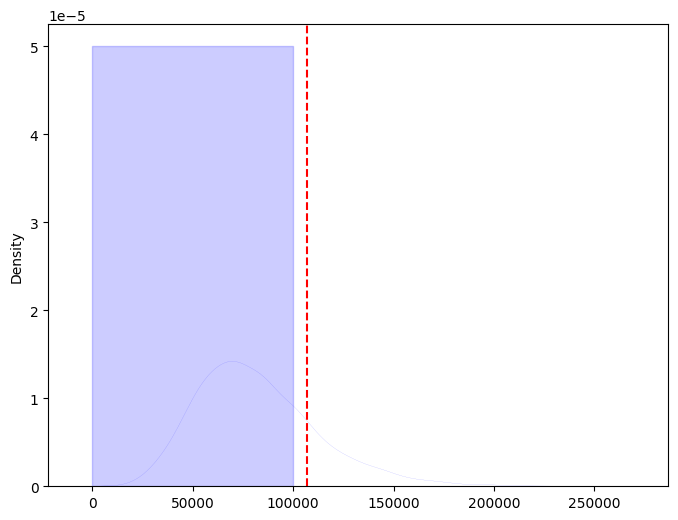

In [142]:
# plot kde of predictions[0] and fille the 95% CI. Then plot the actual value [0] as a red circle
fig, ax = plt.subplots(figsize=(8, 6))
sns.kdeplot(predictions[:,0], label="Predicted", alpha=0.5, linewidth=0.1, color="blue")
# sns.kdeplot(y[0], label="Actual", color="red")
plt.axvline(x=y[0], color="red", linestyle="--")
plt.fill_betweenx([0, 0.00005], 0, 100000, alpha=0.2, color="blue")

In [39]:
# Calculate RMSE and MAE
rmse = np.sqrt(np.mean((predictions.mean(axis=0) - y)**2))
mae = np.mean(np.abs(predictions.mean(axis=0) - y))
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

RMSE: 46731.34765625
MAE: 35682.23046875


In [71]:
# Calculate RMSE and MAE
rmse = np.sqrt(np.mean((predictions.mean(axis=0) - y)**2))
mae = np.mean(np.abs(predictions.mean(axis=0) - y))
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

RMSE: 46726.7734375
MAE: 35678.2109375


In [ ]:
# Calculate RMSE and MAE
rmse = np.sqrt(np.mean((predictions.mean(axis=0) - y)**2))
mae = np.mean(np.abs(predictions.mean(axis=0) - y))
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

RMSE: 46756.80078125
MAE: 35687.328125


In [93]:
from scipy.stats import gaussian_kde

def log_score_empirical(y_true, samples):
    # print(y.shape, samples.shape)
    kde = gaussian_kde(samples)
    pdf_values = kde.evaluate(y_true)
    return np.log(pdf_values)

vectorized_log_score = np.vectorize(log_score_empirical, signature='(),(n)->()')
log_score = vectorized_log_score(y, predictions.T)
mean_log_score = np.mean(log_score)
print(f"Mean log score: {mean_log_score}")

Mean log score: -11.702339106378775


In [72]:
from scipy.stats import gaussian_kde

def log_score_empirical(y_true, samples):
    # print(y.shape, samples.shape)
    kde = gaussian_kde(samples)
    pdf_values = kde.evaluate(y_true)
    return np.log(pdf_values)

vectorized_log_score = np.vectorize(log_score_empirical, signature='(),(n)->()')
log_score = vectorized_log_score(y, predictions.T)
mean_log_score = np.mean(log_score)
print(f"Mean log score: {mean_log_score}")

Mean log score: -12.62512455945057


In [94]:
from scipy.integrate import quad

def crps_kde(y_true, samples):
    kde = gaussian_kde(samples)
    cdf_integral = quad(lambda x: kde.integrate_box_1d(-np.inf, x), -np.inf, y_true)[0]
    pdf_value = kde.evaluate(y_true)
    return (cdf_integral - y_true) ** 2 + 2 / np.sqrt(np.pi) * pdf_value

vectorized_crps = np.vectorize(crps_kde, signature='(),(n)->()')
crps = vectorized_crps(y[:200], predictions.T[:200])
mean_crps = np.mean(crps)
print(f"Mean CRPS: {mean_crps}")

Mean CRPS: 5197905679.8961315


In [79]:
from scipy.integrate import quad

def crps_kde(y_true, samples):
    kde = gaussian_kde(samples)
    cdf_integral = quad(lambda x: kde.integrate_box_1d(-np.inf, x), -np.inf, y_true)[0]
    pdf_value = kde.evaluate(y_true)
    return (cdf_integral - y_true) ** 2 + 2 / np.sqrt(np.pi) * pdf_value

vectorized_crps = np.vectorize(crps_kde, signature='(),(n)->()')
crps = vectorized_crps(y[:200], predictions.T[:200])
mean_crps = np.mean(crps)
print(f"Mean CRPS: {mean_crps}")

Mean CRPS: 5379741614.637691


In [78]:
(16000/100 * 16)/60

42.666666666666664

<Axes: ylabel='Density'>

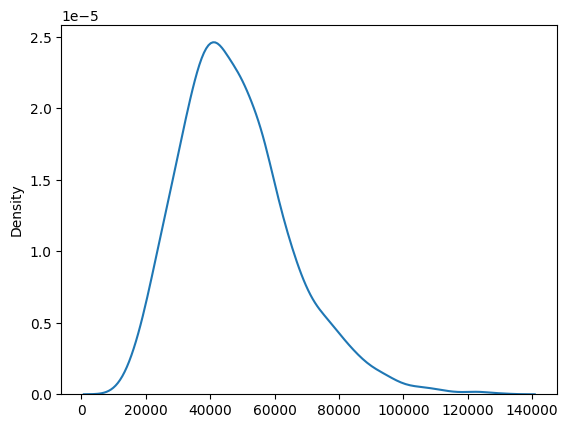

In [50]:
sns.kdeplot(predictions[:, 63])

# Linear regression model

In [41]:
lr_data = pd.read_csv('../datasets/hains_model_dataset.csv', index_col=0)

In [42]:
lr_data = lr_data[lr_data["year"] >= 2008]
lr_data.shape

(14281, 70)

In [43]:
lr_data.columns

Index(['edu', 'edu_level', 'no_edu', 'elementary_edu', 'highschool_edu',
       'postsec_edu', 'undergrad_edu', 'graduate_edu',
       'grad_highschool_refyear', 'grad_college_refyear', 'grad_univ_refyear',
       'ft_student', 'prior_exp', 'some_ps', 'comp_ps', 'ind_g1', 'ind_g2',
       'ind_g3', 'ind_g4', 'ind_g5', 'ind_g6', 'ind_g7', 'ind_g8', 'occup_g1',
       'occup_g2', 'occup_g3', 'occup_g4', 'occup_g5', 'occup_g6', 'occup_g7',
       'occup_g8', 'firm_mloc', 'public_sector', 'private_sector', 'lfs',
       'occup', 'industry', 'self_emp', 'union', 'part_time', 'major_activity',
       'major_source_inc', 'multiple_jobs', 'num_jobs', 'exp', 'reason_pt',
       'hourly_wage', 'hours_paid', 'months_last_worked', 'tenure', 'sex',
       'age', 'year', 'weight', 'salary', 'firm_size', 'loc_size',
       'firm_size_<20', 'firm_size_20 to 99', 'firm_size_100 to 499',
       'firm_size_500 to 999', 'firm_size_+1000', 'loc_size_<20',
       'loc_size_20 to 99', 'loc_size_100 to 499', 

In [39]:
lr_data.edu.unique()

array(['non-university postsecondary certificate', "bachelor's degree",
       '11-13 years of elementary and secondary school (not graduated)',
       'graduated high school', 'university certificate above bachelor',
       'some non-university postsecondary (no certificate)',
       '9-10 years of elementary and secondary school',
       '5-8 years of elementary school',
       'university certificate below bachelor',
       'some university (no certificate)',
       '1-4 years of elementary school', 'never attended school'],
      dtype=object)

In [40]:
lr_data[["sex","union","ft_student","some_ps","comp_ps","undergrad_edu","graduate_edu","tenure","prior_exp",
         "occup_g1","occup_g2","occup_g3","occup_g4","occup_g5","occup_g6","occup_g7","ind_g1","ind_g2","ind_g3","ind_g4","ind_g5","ind_g6",
         "loc_size_20 to 99", "loc_size_100 to 499", "loc_size_500 to 999", "loc_size_+1000", "firm_mloc",  
         ]]

,sex,union,ft_student,some_ps,comp_ps,undergrad_edu,graduate_edu,tenure,tenure,tenure,...,ind_g1,ind_g2,ind_g3,ind_g4,ind_g5,ind_g6,loc_size_20 to 99,loc_size_100 to 499,loc_size_500 to 999,loc_size_+1000
551,0,1,0,0,1,0,0,147.0,147.0,147.0,...,0,0,0,0,0,1,1,0,0,0
553,0,0,0,0,1,0,0,228.0,228.0,228.0,...,0,0,0,1,0,0,1,0,0,0
554,0,1,0,0,1,0,0,136.0,136.0,136.0,...,0,0,0,0,0,0,0,1,0,0
555,0,0,0,0,0,1,0,280.0,280.0,280.0,...,0,0,0,0,0,0,0,0,1,0
556,0,1,0,0,0,0,0,354.0,354.0,354.0,...,0,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66286,0,0,0,0,0,0,0,171.0,171.0,171.0,...,0,0,0,0,1,0,0,0,0,1
66287,1,1,0,0,1,0,0,437.0,437.0,437.0,...,0,0,1,0,0,0,1,0,0,0
66288,0,1,0,0,1,0,0,359.0,359.0,359.0,...,0,0,0,0,0,0,0,1,0,0
66289,0,0,0,1,0,0,0,60.0,60.0,60.0,...,0,0,1,0,0,0,0,0,0,0


In [ ]:
{
    "intercept": 9.45e0,
    "female":
}

In [48]:
y[60:65]aa

array([ 45528.31858407, 106922.56637168,  72431.4159292 , 262132.74336283,
       106922.56637168])

In [57]:
data[data["year"]>=2008].iloc[60:65]

,year,industry,occup,exp,salary,sex,no_edu,elementary_edu,highschool_edu,postsec_edu,...,tenure,union,public_sector,self_emp,age,min_wage,estimated_hourly_wage,below_min_wage,ind_codes,occ_codes
756,2008,health/social,sales/service,-1.244425,45528.318584,1,0,0,1,0,...,0.671191,0,0,0,-0.203864,11.146715,25.015560,0,12,15
757,2008,manufacturing,other trades,1.540541,106922.566372,0,0,0,0,1,...,2.704033,1,0,0,1.277708,11.146715,58.748663,0,4,21
758,2008,public admin,secretarial/administrative,-1.603775,72431.415929,1,0,0,1,0,...,1.143101,1,1,0,-0.018667,11.146715,39.797481,0,15,3
759,2008,finance/real estate,business/finance professional,-0.346049,262132.743363,1,0,0,0,0,...,-0.889741,0,0,0,-0.481658,11.146715,144.028980,0,8,2
760,2008,public admin,business/finance professional,-0.885074,106922.566372,0,0,0,0,0,...,-0.308929,0,1,0,-1.037248,11.146715,58.748663,0,15,2


In [66]:
# get index where log score is -inf
log_score_inf = np.where(log_score == -np.inf)
log_score_inf

(array([3993]),)

In [45]:
log_score.argmin()

63

In [38]:
import numpy as np

def my_function(x, y):
    return np.mean(x * y)

vectorized_function = np.vectorize(my_function, signature='(),(n)->()')
array1 = np.array([1, 2, 3, 4])
array2 = np.array([[1,1,1,1,1,1,1],
                  [2,2,2,2,2,2,2],
                  [3,3,3,3,3,3,3],
                  [4,4,4,4,4,4,4]]) 

new_array = vectorized_function(array1, array2)
new_array

array([ 1.,  4.,  9., 16.])

In [ ]:
mean_log_score_empirical

-11.90758912176725

In [21]:
predictions.mean(axis=0).shape

(16805,)

## Define functions

In [9]:
def kde_estimate(data):
    kde = gaussian_kde(data)
    return kde

In [9]:
def build_params_dist(model):
    params_dist = {}
    for param in model.posterior.data_vars:
        if param.startswith("avg_") or param.startswith("beta_"):
            _, _, dimension = model.posterior[param].values.shape
            values = model.posterior[param].values.reshape(-1, dimension)
            params_dist[param] = [ kde_estimate(values[:, i]) for i in range(dimension) ]
    return params_dist

In [10]:
params_dist = build_params_dist(model)

In [209]:
def predict(features, samples=10000):
    ind_code = int(features["ind_codes"]) - 1
    occ_code = int(features["occ_codes"]) - 1
    features = features.drop(["ind_codes","occ_codes"]).to_dict()

    avg_salary_ind = params_dist["avg_salary"][ind_code].resample(samples).reshape(-1)
    # avg_salary_occ = params_dist["avg_salary_occ"][occ_code].resample(samples).reshape(-1).mean()

    # print(avg_salary_ind, avg_salary_occ)

    salary_ind = np.exp(avg_salary_ind)
    # salary_occ = np.exp(avg_salary_occ)
    for feature in features.items():
        param = feature[0]
        value = feature[1]
        salary_ind += value * np.exp(avg_salary_ind) * (np.exp(params_dist[f"beta_{param}"][ind_code].resample(samples).reshape(-1)) -1)
        # salary_ind += value * np.exp(avg_salary_ind) * (np.exp(params_dist[f"beta_{param}_ind"][ind_code].resample(samples).reshape(-1).mean()) -1)
        # salary_occ += value * np.exp(avg_salary_occ) * (np.exp(params_dist[f"beta_{param}_occ"][ind_code].resample(samples).reshape(-1).mean()) -1)
    return salary_ind

In [210]:
drop_cols = ["year","industry","occup","salary","no_edu","min_wage","estimated_hourly_wage","below_min_wage"]
# data["salary_mean_pred"] = data[data["year"]>=2008].drop(drop_cols, axis=1).apply(predict, axis=1)

In [220]:
with open("../outputs/hierarchical/2007/predictive.pickle", "rb") as f:
    predictive = pickle.load(f)

AttributeError: Can't get attribute 'hierarchical' on <module '__main__'>

In [211]:
data_pred = data[data["year"]>=2011].copy()

In [212]:
data.iloc[10].salary

148061.45251396648

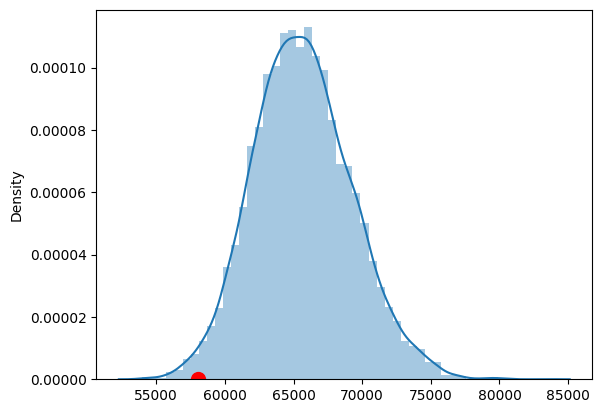

In [217]:
x = predict(data.iloc[9000].drop(drop_cols))
sns.distplot(x)
# Plot a red circle for the observed value of the salary 148061.0
plt.scatter(data.iloc[9000].salary, 0, color="red", marker="o", s=100)

In [200]:
data_pred["pred"] = data_pred.drop(drop_cols, axis=1).apply(predict, axis=1)

KeyboardInterrupt: 

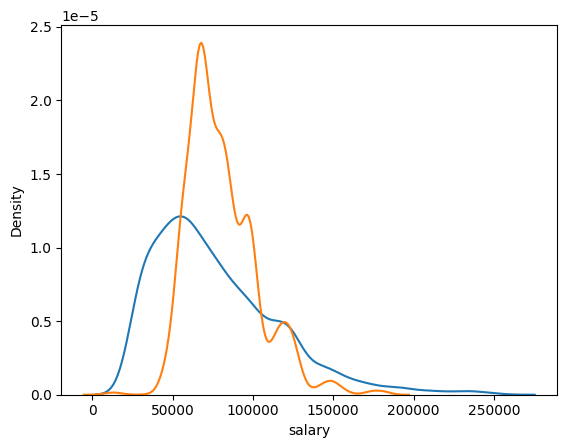

In [195]:
fig, ax = plt.subplots()

sns.kdeplot(data_pred.salary, label="Observed", ax=ax)
sns.kdeplot(data_pred.pred, label="Predicted", ax=ax);

In [170]:
np.exp(9.54)

13904.947624579181

In [104]:
(model.posterior["beta_exp_ind"].values[:,:,0].flatten().mean())

0.047022894

In [105]:
(model.posterior["beta_exp_occ"].values[:,:,0].flatten().mean())

0.048084687

In [101]:
111.72757 * 79.03706

8830.618653744199

In [93]:
data.iloc[100]

year                                    1998
industry                  accommodation/food
occup                    chefs/food services
exp                                -1.513937
salary                          48234.254144
sex                                        0
no_edu                                     0
elementary_edu                             0
highschool_edu                             0
postsec_edu                                1
undergrad_edu                              0
graduate_edu                               0
tenure                             -0.399681
union                                      0
public_sector                              0
self_emp                                   0
age                                -1.685435
min_wage                           11.894432
estimated_hourly_wage              26.502337
below_min_wage                             0
ind_codes                                 13
occ_codes                                 14
Name: 118,

In [276]:
predict(.iloc[0])

66698.41693745209

In [278]:
data.salary

2          78385.474860
5          32225.139665
8          62708.379888
12        104513.966480
13         40063.687151
              ...      
241315     45073.129252
241327     89483.418367
241328     43747.448980
241329     25850.765306
241331     13256.802721
Name: salary, Length: 80121, dtype: float64

In [279]:
data.iloc[-1]

year                                  2010
industry                             trade
occup                      clerks/cashiers
exp                               -0.51347
salary                        13256.802721
sex                                      1
no_edu                                   0
elementary_edu                           0
highschool_edu                           0
postsec_edu                              1
undergrad_edu                            0
graduate_edu                             0
grad_highschool_refyear                  0
grad_college_refyear                     0
grad_univ_refyear                        0
tenure                           -0.392716
union                                    0
part_time                                0
public_sector                            0
self_emp                                 0
age                                0.40748
firm_size                                1
loc_size                                 1
ind_codes  

In [98]:
params = build_params_dist(model)
params.keys()

dict_keys(['avg_salary_ind', 'avg_salary_occ', 'beta_age_ind', 'beta_age_occ', 'beta_elementary_edu_ind', 'beta_elementary_edu_occ', 'beta_exp_ind', 'beta_exp_occ', 'beta_graduate_edu_ind', 'beta_graduate_edu_occ', 'beta_highschool_edu_ind', 'beta_highschool_edu_occ', 'beta_part_time_ind', 'beta_part_time_occ', 'beta_postsec_edu_ind', 'beta_postsec_edu_occ', 'beta_public_sector_ind', 'beta_public_sector_occ', 'beta_self_emp_ind', 'beta_self_emp_occ', 'beta_sex_ind', 'beta_sex_occ', 'beta_tenure_ind', 'beta_tenure_occ', 'beta_undergrad_edu_ind', 'beta_undergrad_edu_occ', 'beta_union_ind', 'beta_union_occ'])

In [86]:
params["avg_salary_occ"][0].resample(1000).mean()

5.127747899283384

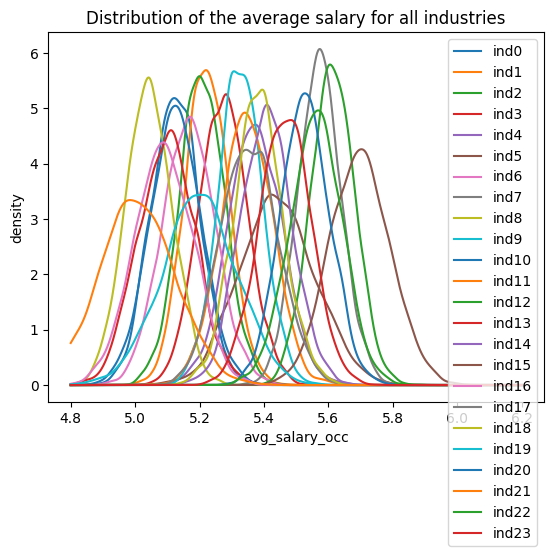

In [82]:
# plot the distribution of the average salary for all industries using seaborn
import seaborn as sns
import matplotlib.pyplot as plt

def plot_params_dist(params, param_name, title):
    fig, ax = plt.subplots()
    x = np.linspace(4.8, 6.2, 1000)
    for i, kde in enumerate(params[param_name]):
        sns.lineplot(x=x, y=kde(x), label=f'ind{i}', ax=ax)
    ax.set_title(title)
    ax.set_xlabel(param_name)
    ax.set_ylabel("density")
    ax.legend()
    plt.show()

plot_params_dist(params, "avg_salary_occ", "Distribution of the average salary for all industries")

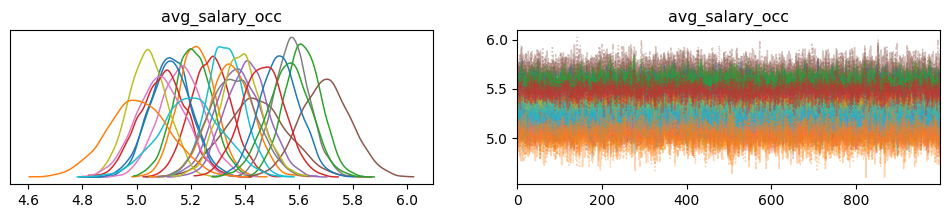

In [83]:
az.plot_trace(model, var_names=["avg_salary_occ"], combined=True);

In [57]:
len(params["avg_salary_ind"])

4000

In [25]:
params["avg_salary_ind"](10)

array([0.])